## Yum or Yuck Butterfly Mimics 2022 – Explore Dataset

**Author:** [Keith Pinson](https://github.com/keithpinson)<br>
**Date created:** 2022/06/28<br>
**Version:** 1.0.0001<br>
**Description:** Explore the dataset<br>


In [1]:
import datetime

print("executed",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),"local time")

executed 2022-07-21 15:20:13 local time


## &nbsp;
---
## Set Environment
---

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from skimage import io


### <u>Dataset paths and names</u>

In [3]:
dataset_name = "YOYMimics-2022-dataset"

# Setting the variables assuming a Windows platform
base_dir = "."
data_dir = os.path.join(base_dir, dataset_name, 'data', 'butterfly_mimics')
working_dir = os.path.join(os.environ.get("HOMEPATH"), dataset_name)
temp_dir = os.path.join(os.environ.get("TMP"), dataset_name)

train_dir = os.path.join(data_dir, 'images')
test_dir = os.path.join(data_dir, 'image_holdouts')
train_csv = os.path.join(data_dir, 'images.csv')
test_csv = os.path.join(data_dir, 'image_holdouts.csv')
submit_csv = os.path.join(base_dir, 'sample_submission.csv')

# We will create these files from the provided csv files
working_train_csv = os.path.join(working_dir, 'working_images.csv')
working_test_csv = os.path.join(working_dir, "working_image_holdouts.csv")

### &nbsp;
---
### Check our Dataset Environment
---


### First, what does our directory structure look like?
```
.
├── image_holdouts
│   ├── gna250129d.jpg
│   ├── goabc6e644.jpg
│   ├── gpcb27504e.jpg
╎   ╎
│   └── zx54a72a62.jpg
├── images
│   ├── ggc1e08cbc.jpg
│   ├── gh150f104b.jpg
│   ├── gh20ab0d9c.jpg
╎   ╎
│   └── zze50f4f4f.jpg
├── image_holdouts.csv
└── images.csv
```

### <u>Datasets</u>

Notice that folders and files contain no naming information to indicate the butterfly species. This information is contained in the CSV files. So we will have to read the `'images.csv'` to get the training labels.

In [ ]:
# Extract the dataset
train_csv_data = pd.read_csv(train_csv)
test_csv_data = pd.read_csv(test_csv)

### &nbsp;
---
### Explore Training Dataset
---


### What do the csv files look like?

In [ ]:
print("From the images.csv file:")
print("-------------------------")
train_csv_data.head()

The `'image'` field will be transformed to the image feature and the `'name'` will be encoded to become the label. The `'stage'` field can be dropped since there are no caterpillars in the dataset. Advanced models may find the `'side'` field useful.

### &nbsp;
### What species of butterflies do we have?

In [ ]:
print(train_csv_data['name'].unique())

### &nbsp;
### How many images of each do we have?

In [ ]:
print("Total:\t\t", train_csv_data['name'].count())
print("")
print(train_csv_data['name'].value_counts())

### &nbsp;
### Let's visualize the count

In [ ]:
fig = plt.figure(figsize=(16, 5))
sns.set_theme(font_scale=2,palette="Set2")
sns.countplot(x=train_csv_data['name'],
            order=train_csv_data['name'].value_counts().index).set(title='Count of Butterfly by Species')
plt.xticks(rotation=0);

### &nbsp;
### Let's visualize the size of the image data?

In [ ]:
first_file = os.path.join(train_dir, train_csv_data.image[1]+".jpg")

image = io.imread(first_file, as_gray=False)

figure = plt.figure()
ax = figure.add_axes([0, 0, 1, 1])

ax.grid(None)
ax.axis('on')

ax.xaxis.labelpad = 20
ax.xaxis.set_label_text(f'Shape: {image.shape}')
plt.imshow(image,  interpolation_stage='rgb')
plt.show()



All images are 224x224 pixel RGB photos.

### &nbsp;
### What do the images look like?

In [ ]:
# Run or re-run this to start at the first image
j = 0


In [ ]:
# Run this cell over and over to step through the images

rows = 5
cols = 5

plt.style.use("default")
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(13, 13))

plt.suptitle("Training Dataset of Butterfly Mimics", fontsize=20)

data_length = len(train_csv_data)
maxloop = data_length//(rows*cols)

if j <= maxloop:
    for i, ax in enumerate(axs.flat):
        k = (j*rows*cols) + i

        if k < data_length:
            file = os.path.join(train_dir, train_csv_data.image[k]+".jpg")
            image = io.imread(file, as_gray=False)

            ax.grid(None)
            ax.axis('on')

            ax.imshow(image, interpolation_stage='rgb')
            ax.set(xticks=[], yticks=[], xlabel = train_csv_data.name[k])
        else:
            ax.set_visible(False)

    fig.text(.83, .965, f"page {j+1}", color='grey', fontsize=14)

    j = j + 1 if j < maxloop else 0
    plt.show()

### &nbsp;
### Do we have any missing data?

In [ ]:
print("Missing data from the images.csv file:")
print("--------------------------------------")
train_csv_data.isna().sum()

---
### Explore Test Dataset
---


### What do the test csv files look like?

In [13]:
print("From the image_holdouts.csv file:")
print("---------------------------------")

test_csv_data.head()

From the image_holdouts.csv file:
---------------------------------


,image
0,goabc6e644
1,gpcb27504e
2,gsc64524dc
3,guf6eae7c8
4,gw3d42f465


### &nbsp;
### What do the test images look like?

In [14]:
# Run and then re-run this cell to start with the first image
j = 0

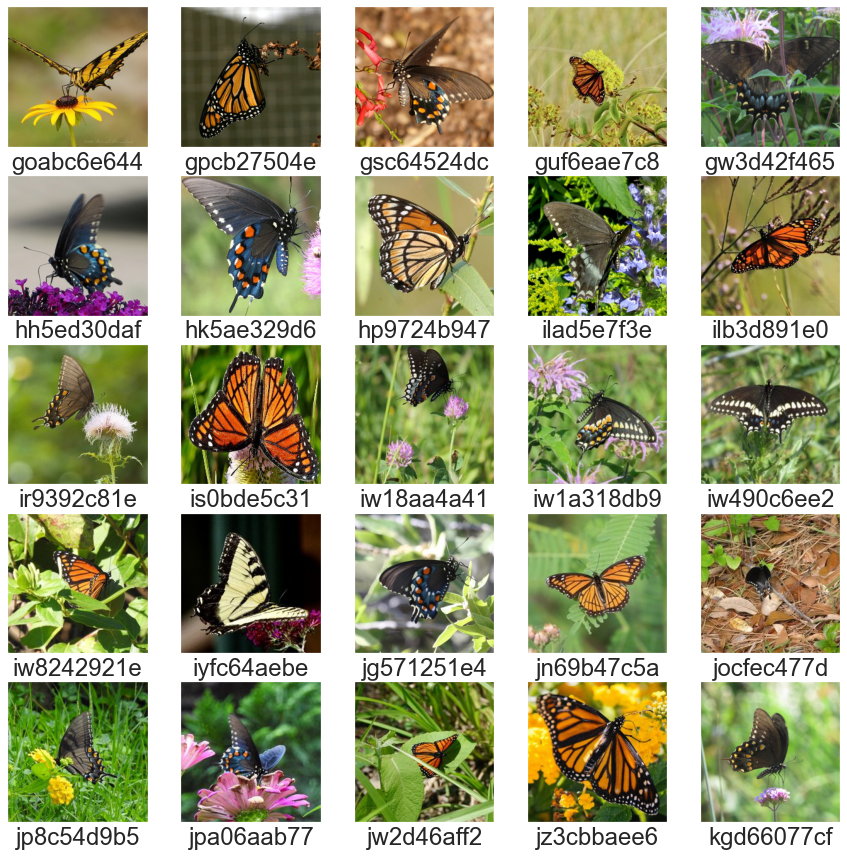

In [15]:

fig, ax = plt.subplots(5, 5, figsize=(15, 15))

maxloop = int(len(test_csv_data)/25)+1

if j < maxloop:
    for i, axi in enumerate(ax.flat):
        k = (j*25) + i

        if k < len(test_csv_data):
            file = os.path.join(test_dir, test_csv_data.image[k]+".jpg")
            image = io.imread(file, as_gray=False)

            axi.grid(None)
            axi.axis('on')

            axi.imshow(image, interpolation_stage='rgb')
            axi.set(xticks=[], yticks=[], xlabel = test_csv_data.image[k])
        else:
            axi.set_visible(False)

    j = j + 1
    plt.show()

### &nbsp;
---
### Explore Submissions
---

### What should a submission look like?

In [16]:
print("Example Submission")
print("------------------")
submit_ds = pd.read_csv(submit_csv)
submit_ds.head()

Example Submission
------------------


,image,name,confidence
0,gna250129d,black,0.75
1,goabc6e644,monarch,0.75
2,gpcb27504e,pipevine,0.75
3,gsc64524dc,spicebush,0.75
4,guf6eae7c8,tiger,0.75


The name is submitted with a confidence value, for example image `goabc6e644` is a `monarch` with 75% confidence.

### &nbsp;
### That's it. Everything looks good!